In [1]:
import pandas as pd
import numpy as np

In [2]:
INPUT = "./all_companies_with_sectors_corrected_final.csv"

# 1) load data
df = pd.read_csv(INPUT, parse_dates=["Date"], low_memory=False)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

cols = ["PX_LAST", "REVENUE", "NET_INCOME", "IS_RD_EXPEND", "CAPEX", "CUR_MKT_CAP","CF_FREE_CASH_FLOW"]
for c in cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["CUR_MKT_CAP"])

vars_to_agg = ["PX_LAST", "REVENUE", "NET_INCOME", "IS_RD_EXPEND", "CAPEX","CF_FREE_CASH_FLOW"]
df = df.dropna(subset=vars_to_agg, how="all")


df["Quarter"] = df["Date"].dt.to_period("Q").astype(str)

def weighted_agg(group, value_cols, weight_col="CUR_MKT_CAP"):
    w = group[weight_col] if weight_col in group.columns else pd.Series(np.nan, index=group.index)
    out = {}
    for col in value_cols:
        if col not in group.columns:
            out[col] = np.nan
            continue
        val = group[col]
        mask = val.notna() & w.notna() & (w > 0)
        if mask.sum() == 0:
            out[col] = np.nan
        else:
            out[col] = np.average(val[mask], weights=w[mask])
    return pd.Series(out)


sector_df = (
    df.groupby(["Stream", "Quarter"])
      .apply(lambda g: weighted_agg(g, vars_to_agg, weight_col="CUR_MKT_CAP"), include_groups=False)
      .reset_index()
)

print("Aggregated shape:", sector_df.shape)
display(sector_df.head(20))

Aggregated shape: (1529, 8)


,Stream,Quarter,PX_LAST,REVENUE,NET_INCOME,IS_RD_EXPEND,CAPEX,CF_FREE_CASH_FLOW
0,Downstream (Automotive Semiconductors),2000Q2,59.538,1830.0,266.0,237.0,NaN,NaN
1,Downstream (Automotive Semiconductors),2000Q3,39.572,2380.0,581.0,348.0,NaN,NaN
2,Downstream (Automotive Semiconductors),2000Q4,28.560,1658.0,280.0,257.0,NaN,NaN
3,Downstream (Automotive Semiconductors),2001Q1,30.762,1650.0,23.0,269.0,NaN,NaN
4,Downstream (Automotive Semiconductors),2001Q2,20.460,1277.0,-371.0,318.0,NaN,NaN
5,Downstream (Automotive Semiconductors),2001Q3,9.972,1085.0,-523.0,344.0,NaN,NaN
6,Downstream (Automotive Semiconductors),2001Q4,16.952,1034.0,-331.0,267.0,221.0,-336.0
7,Downstream (Automotive Semiconductors),2002Q1,19.190,1385.0,-108.0,264.0,145.0,-265.0
8,Downstream (Automotive Semiconductors),2002Q2,11.803,1404.0,-76.0,237.0,64.0,229.0
9,Downstream (Automotive Semiconductors),2002Q3,4.144,1384.0,-506.0,292.0,213.0,-34.0


In [3]:
from statsmodels.tsa.stattools import adfuller

# ---------------------------------------------
# 1. Make sector_df['Quarter'] as PeriodIndex
# ---------------------------------------------

if not isinstance(sector_df['Quarter'], pd.PeriodDtype):
    sector_df['Quarter'] = pd.PeriodIndex(sector_df['Quarter'].astype(str), freq='Q')


# ---------------------------------------------
# 2. Prepare ADF test
# ---------------------------------------------
def adf_pval(series):
    s = series.dropna().astype(float)
    if len(s) < 10:
        return np.nan
    try:
        result = adfuller(s, autolag='AIC')
        return result[1]  # p-value
    except Exception:
        return np.nan

usable = []      # [(sector, variable, transform)]
unstable = []    # [(sector, variable, last_pvalue)]

# ---------------------------------------------
# 3. Loop through sectors and variables
# ---------------------------------------------
sectors = sector_df['Stream'].unique().tolist()
variables = [var for var in vars_to_agg if var not in ["PX_LAST", "CUR_MKT_CAP"]]

for sector in sectors:
    for var in variables:
        try:
            mask = (
                (sector_df["Quarter"] > pd.Period("2000Q1", freq='Q')) &
                (sector_df["Quarter"] <= pd.Period("2025Q2", freq='Q')) &
                (sector_df["Stream"] == sector)
            )
            tmp = sector_df.loc[mask].sort_values("Quarter")
            s = tmp[var].dropna().astype(float)

            if len(s) < 12:
                continue

            # 1) Original Test
            p = adf_pval(s)
            if p is not np.nan and p < 0.05:
                usable.append((sector, var, "original"))
                continue

            # 2) Diff(1)
            s_diff = s.diff().dropna()
            p_diff = adf_pval(s_diff)
            if p_diff is not np.nan and p_diff < 0.05:
                usable.append((sector, var, "diff(1)"))
                continue

            # 3) Log().diff(1) (Only for positive values, and with at least 13 values)
            s_pos = s[s > 0]   # Avoiding 0 or negative values
            if len(s_pos) < 12:
                # Too short to test log-diff
                unstable.append((sector, var, p, p_diff, np.nan))
                continue
            s_logdiff = np.log(s_pos).diff().dropna()
            p_logdiff = adf_pval(s_logdiff)
            if p_logdiff is not np.nan and p_logdiff < 0.05:
                usable.append((sector, var, "log().diff(1)"))
                continue

            # If none of the above tests are successful, consider the series as unstable
            unstable.append((sector, var, p, p_diff, p_logdiff))
        except Exception as e:
            unstable.append((sector, var, "error", str(e), None))

# ---------------------------------------------
# 4. Save Results
# ---------------------------------------------

usable_df = pd.DataFrame(usable, columns=["Sector", "Variable", "Transform"])
unstable_df = pd.DataFrame(unstable, columns=["Sector", "Variable", "p_original", "p_diff", "p_logdiff"])

print("✅ Usable:", len(usable_df))
print("⚠️ Unstable:", len(unstable_df))

usable_df.head(20)


✅ Usable: 54
⚠️ Unstable: 6


,Sector,Variable,Transform
0,Downstream (Automotive Semiconductors),REVENUE,diff(1)
1,Downstream (Automotive Semiconductors),NET_INCOME,diff(1)
2,Downstream (Automotive Semiconductors),IS_RD_EXPEND,diff(1)
3,Downstream (Automotive Semiconductors),CAPEX,diff(1)
4,Downstream (Automotive Semiconductors),CF_FREE_CASH_FLOW,diff(1)
5,Downstream (IC Design),REVENUE,log().diff(1)
6,Downstream (IC Design),NET_INCOME,diff(1)
7,Downstream (IC Design),IS_RD_EXPEND,log().diff(1)
8,Downstream (IC Design),CAPEX,diff(1)
9,Downstream (IC Design),CF_FREE_CASH_FLOW,log().diff(1)


In [4]:
# To CSV
usable_df.to_csv("./adf_usable_combinations.csv", index=False)
unstable_df.to_csv("./adf_unstable_combinations.csv", index=False)

In [5]:
from statsmodels.tsa.stattools import adfuller

variables = [var for var in vars_to_agg if var not in ["PX_LAST", "CUR_MKT_CAP"]]
sectors_to_plot = [
    'End Applications (Consumer Electronics)',
    'Upstream (Equipment & Materials)'
]
def adf_test(series, name="", var_name=""):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}, {var_name} ")
    print(f"  Test Statistic : {result[0]:.6f}")
    print(f"  p-value         : {result[1]:.6f}")
    if result[1] < 0.05:
        print("  ✅ Stationary (reject H0)")
    else:
        print("  ❌ Non-stationary (cannot reject H0)")
        series_diff = series.diff().dropna()
        result = adfuller(series_diff)
        if result[1] < 0.05:
            print("  ✅ Diff Stationary (reject H0)")
            print(f"  Test Statistic : {result[0]:.6f}")
            print(f"  p-value         : {result[1]:.6f}")
        else:
            print("  ❌ Diff Non-stationary (cannot reject H0)")
            series_diff_log = np.log(series).diff().dropna()
            result = adfuller(series_diff_log)
            if result[1] < 0.05:
                print("  ✅ Log-Diff Stationary (reject H0)")
                print(f"  Test Statistic : {result[0]:.6f}")
                print(f"  p-value         : {result[1]:.6f}")
            else:
                print("  ❌ Log-Diff Non-stationary (cannot reject H0)")
    print("-"*40)


adf_test(tmp["NET_INCOME"], 'End Applications (Consumer Electronics)',"NET_INCOME")
adf_test(tmp["IS_RD_EXPEND"], 'Upstream (Equipment & Materials)',"IS_RD_EXPEND")

ADF Test for End Applications (Consumer Electronics), NET_INCOME 
  Test Statistic : 4.058706
  p-value         : 1.000000
  ❌ Non-stationary (cannot reject H0)
  ❌ Diff Non-stationary (cannot reject H0)
  ✅ Log-Diff Stationary (reject H0)
  Test Statistic : -5.269354
  p-value         : 0.000006
----------------------------------------
ADF Test for Upstream (Equipment & Materials), IS_RD_EXPEND 
  Test Statistic : 3.239331
  p-value         : 1.000000
  ❌ Non-stationary (cannot reject H0)
  ❌ Diff Non-stationary (cannot reject H0)
  ✅ Log-Diff Stationary (reject H0)
  Test Statistic : -4.572163
  p-value         : 0.000145
----------------------------------------


C:\Users\asdf5\Desktop\FS\DA\1\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import ccf

# ---------------------------------------------
# 1. Filter and align the two sectors
# ---------------------------------------------
sectorA = sector_df[
        (sector_df["Quarter"] > "2010Q1") & (sector_df["Quarter"] <= "2025Q2") &
        (sector_df["Stream"] == "End Applications (Consumer Electronics)")
    ].sort_values("Quarter")["NET_INCOME"]

sectorB = (
    sector_df[
        (sector_df["Quarter"] > "2010Q1")
        & (sector_df["Quarter"] <= "2025Q2")
        & (sector_df["Stream"] == "Upstream (Equipment & Materials)")
    ]
    .sort_values("Quarter")["IS_RD_EXPEND"]
)

sectorA = sectorA.dropna()
sectorB = sectorB.dropna()

def apply_transform(series, transform_type):
    series = series.astype(float)
    if transform_type == "original":
        return series.dropna()
    elif transform_type == "diff(1)":
        return series.diff().dropna()
    elif transform_type == "log().diff(1)":
        series_no_zero = series.replace(0, np.nan)
        series_positive = series_no_zero[series_no_zero > 0]
        if len(series_positive) < 10:
            return None
        return np.log(series_positive).diff().dropna()
    return None
usable_lookup = usable_df.set_index(['Sector', 'Variable'])['Transform'].to_dict()
transformA = usable_lookup.get(("End Applications (Consumer Electronics)", "NET_INCOME"))
transformB = usable_lookup.get(("Upstream (Equipment & Materials)", "IS_RD_EXPEND"))


sectorA_transformed = apply_transform(sectorA, transformA)
sectorB_transformed = apply_transform(sectorB, transformB)


# --- 2.3. 對齊時間序列 ---
# 使用 'inner' join 來確保兩個序列在相同的時間點上對齊
aligned_data = pd.concat([sectorA_transformed, sectorB_transformed], axis=1, join='inner')
aligned_data.columns = ['A', 'B']

sectorA = aligned_data['A']
sectorB = aligned_data['B']


# ---------------------------------------------
# 2. Compute cross-correlation for both directions
# ---------------------------------------------
corr_pos = ccf(sectorA, sectorB, adjusted=False)  # A leads B (正延遲)
corr_neg = ccf(sectorB, sectorA, adjusted=False)  # B leads A (負延遲)

max_lag = 4  # 顯示前後 4 期的延遲

corr_pos_lags = corr_pos[:max_lag + 1]
corr_neg_lags = corr_neg[1:max_lag + 1] # 從 lag 1 開始，避免重複 lag 0

# 合併正負延遲的結果
corr_full = np.concatenate((corr_neg_lags[::-1], corr_pos_lags))
lags = list(range(-max_lag, max_lag + 1))

# ---------------------------------------------
# 3. Plot
# ---------------------------------------------
plt.figure(figsize=(14, 8))
plt.bar(lags, corr_full, color="steelblue", width=0.5)
plt.axhline(0, color="k", linewidth=0.8)
plt.title(
    "Cross-correlation between End Applications (Consumer Electronics) Net Income\n"
    "and End Upstream (Equipment & Materials) R&D Expenditure", fontsize=18, fontweight="bold"
)
plt.xlabel("Lag (quarters)", fontsize=14)
plt.ylabel("Correlation", fontsize=14)
plt.xticks(range(-max_lag, max_lag + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 4. Print correlation values for interpretation
# ---------------------------------------------
print("Cross-correlation values (negative → B leads A, positive → A leads B):")
for lag, val in zip(lags, corr_full):
    print(f"Lag {lag:+d}: {val:.4f}")


C:\Users\asdf5\Desktop\FS\DA\1\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1116: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
C:\Users\asdf5\Desktop\FS\DA\1\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\asdf5\Desktop\FS\DA\1\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1117: RuntimeWarning: Mean of empty slice.
  yo = y - y.mean()


IndexError: index 0 is out of bounds for axis 0 with size 0

In [19]:
from statsmodels.tsa.stattools import grangercausalitytests

data = pd.concat([sectorA.reset_index(drop=True), sectorB.reset_index(drop=True)], axis=1)
data.columns = sectors_to_plot

grangercausalitytests(data, maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5183  , p=0.4746  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=0.5460  , p=0.4599  , df=1
likelihood ratio test: chi2=0.5435  , p=0.4610  , df=1
parameter F test:         F=0.5183  , p=0.4746  , df_denom=56, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3450  , p=0.1057  , df_denom=53, df_num=2
ssr based chi2 test:   chi2=5.1324  , p=0.0768  , df=2
likelihood ratio test: chi2=4.9178  , p=0.0855  , df=2
parameter F test:         F=2.3450  , p=0.1057  , df_denom=53, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3409  , p=0.0265  , df_denom=50, df_num=3
ssr based chi2 test:   chi2=11.4260 , p=0.0096  , df=3
likelihood ratio test: chi2=10.4140 , p=0.0154  , df=3
parameter F test:         F=3.3409  , p=0.0265  , df_denom=50, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7097  , p=0.0412  , df_d

{np.int64(1): ({'ssr_ftest': (np.float64(0.5182604144118758),
    np.float64(0.47457871753119274),
    np.float64(56.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.5460243651839405),
    np.float64(0.45994670191032405),
    np.int64(1)),
   'lrtest': (np.float64(0.5435132142438022),
    np.float64(0.4609803724924886),
    np.int64(1)),
   'params_ftest': (np.float64(0.5182604144118911),
    np.float64(0.4745787175311874),
    np.float64(56.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.3449552987727404),
    np.float64(0.10572169010164607),
    np.float64(53.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(5.132354993540337),
    np.float64(0.07682866265736957),
    np.int64(2)),
   'lrtest': (np.float64(4.917842330634656),
    np.float64(0.08552717089161908),
    np.int64(2)),
   'params_ftest': (np.float64(2.344955298772735),
    np.float64(0.10572169010164639),
    np.float64(53.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
       

In [20]:
data = pd.concat([sectorB.reset_index(drop=True), sectorA.reset_index(drop=True)], axis=1)
data.columns = sectors_to_plot

grangercausalitytests(data, maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4240  , p=0.1251  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=2.5539  , p=0.1100  , df=1
likelihood ratio test: chi2=2.5002  , p=0.1138  , df=1
parameter F test:         F=2.4240  , p=0.1251  , df_denom=56, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6487  , p=0.2020  , df_denom=53, df_num=2
ssr based chi2 test:   chi2=3.6085  , p=0.1646  , df=2
likelihood ratio test: chi2=3.5007  , p=0.1737  , df=2
parameter F test:         F=1.6487  , p=0.2020  , df_denom=53, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9862  , p=0.1280  , df_denom=50, df_num=3
ssr based chi2 test:   chi2=6.7930  , p=0.0788  , df=3
likelihood ratio test: chi2=6.4177  , p=0.0930  , df=3
parameter F test:         F=1.9862  , p=0.1280  , df_denom=50, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2834  , p=0.0743  , df_d

{np.int64(1): ({'ssr_ftest': (np.float64(2.424021298839538),
    np.float64(0.12512182168793257),
    np.float64(56.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.553879582705942),
    np.float64(0.11002378883443212),
    np.int64(1)),
   'lrtest': (np.float64(2.500150850196974),
    np.float64(0.11383539377896947),
    np.int64(1)),
   'params_ftest': (np.float64(2.4240212988395595),
    np.float64(0.12512182168793173),
    np.float64(56.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.648710622238394),
    np.float64(0.2020064516996245),
    np.float64(53.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.6084987203708248),
    np.float64(0.16459796400174023),
    np.int64(2)),
   'lrtest': (np.float64(3.50069536954976),
    np.float64(0.17371353539812512),
    np.int64(2)),
   'params_ftest': (np.float64(1.6487106222383883),
    np.float64(0.2020064516996251),
    np.float64(53.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
          

In [7]:
import seaborn as sns
import matplotlib.ticker as ticker

def plot_sector_comparison(sector_df, sector1, column1, sector2, column2, lag=0):
    # -------------------------------------------------
    # 1. Filter the data for the desired period & sectors
    # -------------------------------------------------
    df = sector_df[
        (sector_df["Quarter"] > "2010Q1") &
        (sector_df["Quarter"] <= "2025Q2") &
        (sector_df["Stream"].isin([sector1, sector2]))
        ].copy()

    print(f"Selected sectors: {sector1} ({column1}), {sector2} ({column2})")
    print(f"Filtered dataset shape: {df.shape}")

    # -------------------------------------------------
    # 2. Create separate dataframes for each sector
    # -------------------------------------------------
    df1 = df[df["Stream"] == sector1].copy()
    df2 = df[df["Stream"] == sector2].copy()

    # Shift sector 1 data by one quarter forward
    # Use the 'lag' parameter to make the shift dynamic
    df1["Quarter"] = pd.PeriodIndex(df1["Quarter"], freq="Q").shift(lag).astype(str)

    # -------------------------------------------------
    # 3. Compute Z-score normalization for each column per sector
    # -------------------------------------------------
    df1[f"{column1}_ZSCORE"] = (df1[column1] - df1[column1].mean()) / df1[column1].std(ddof=0)
    df2[f"{column2}_ZSCORE"] = (df2[column2] - df2[column2].mean()) / df2[column2].std(ddof=0)

    # Drop missing values
    df1 = df1.dropna(subset=[f"{column1}_ZSCORE"])
    df2 = df2.dropna(subset=[f"{column2}_ZSCORE"])

    print("Data after Z-score normalization:")
    print(f"Sector 1: {df1[['Stream', 'Quarter', f'{column1}_ZSCORE']].head()}")
    print(f"Sector 2: {df2[['Stream', 'Quarter', f'{column2}_ZSCORE']].head()}")

    # -------------------------------------------------
    # 4. Combine data for plotting
    # -------------------------------------------------
    df1_plot = df1[["Quarter", f"{column1}_ZSCORE"]].copy()
    df1_plot["Label"] = f"{sector1} - {column1}"
    df1_plot.rename(columns={f"{column1}_ZSCORE": "ZSCORE"}, inplace=True)

    df2_plot = df2[["Quarter", f"{column2}_ZSCORE"]].copy()
    df2_plot["Label"] = f"{sector2} - {column2}"
    df2_plot.rename(columns={f"{column2}_ZSCORE": "ZSCORE"}, inplace=True)

    df_combined = pd.concat([df1_plot, df2_plot], ignore_index=True)


    df_combined["Quarter"] = df_combined["Quarter"].astype(str)

    # -------------------------------------------------
    # 5. Plot using Seaborn
    # -------------------------------------------------
    sns.set(style="whitegrid", context="talk")

    plt.figure(figsize=(30, 7))
    sns.lineplot(
        data=df_combined,
        x="Quarter",
        y="ZSCORE",
        hue="Label",
        lw=2,
        marker="o"
    )

    # -------------------------------------------------
    # 6. Chart styling
    # -------------------------------------------------
    if lag != 0:
        title_lag_text = f" (Lagged by {lag} Quarters)"
    else:
        title_lag_text = ""
    plt.title(f"Comparison: {sector1} ({column1}) vs {sector2} ({column2}) - Z-score Normalized{title_lag_text}", fontsize=18, fontweight="bold")
    plt.xlabel("Date", fontsize=14)
    plt.xticks(rotation=90)
    # plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))

    plt.ylabel("Normalized Value (Z-score)", fontsize=14)
    plt.legend(title="Sector - Variable", loc="upper left")
    plt.grid(alpha=0.3)
    plt.show()


Selected sectors: End Applications (Consumer Electronics) (NET_INCOME), Upstream (Equipment & Materials) (IS_RD_EXPEND)
Filtered dataset shape: (122, 8)
Data after Z-score normalization:
Sector 1:                                        Stream Quarter  NET_INCOME_ZSCORE
1151  End Applications (Consumer Electronics)  2010Q2          -1.352842
1152  End Applications (Consumer Electronics)  2010Q3          -1.244955
1153  End Applications (Consumer Electronics)  2010Q4          -1.117519
1154  End Applications (Consumer Electronics)  2011Q1          -1.128721
1155  End Applications (Consumer Electronics)  2011Q2          -0.968353
Sector 2:                                 Stream Quarter  IS_RD_EXPEND_ZSCORE
1467  Upstream (Equipment & Materials)  2010Q2            -1.049700
1468  Upstream (Equipment & Materials)  2010Q3            -1.026480
1469  Upstream (Equipment & Materials)  2010Q4            -1.050893
1470  Upstream (Equipment & Materials)  2011Q1            -0.970447
1471  Upstream 

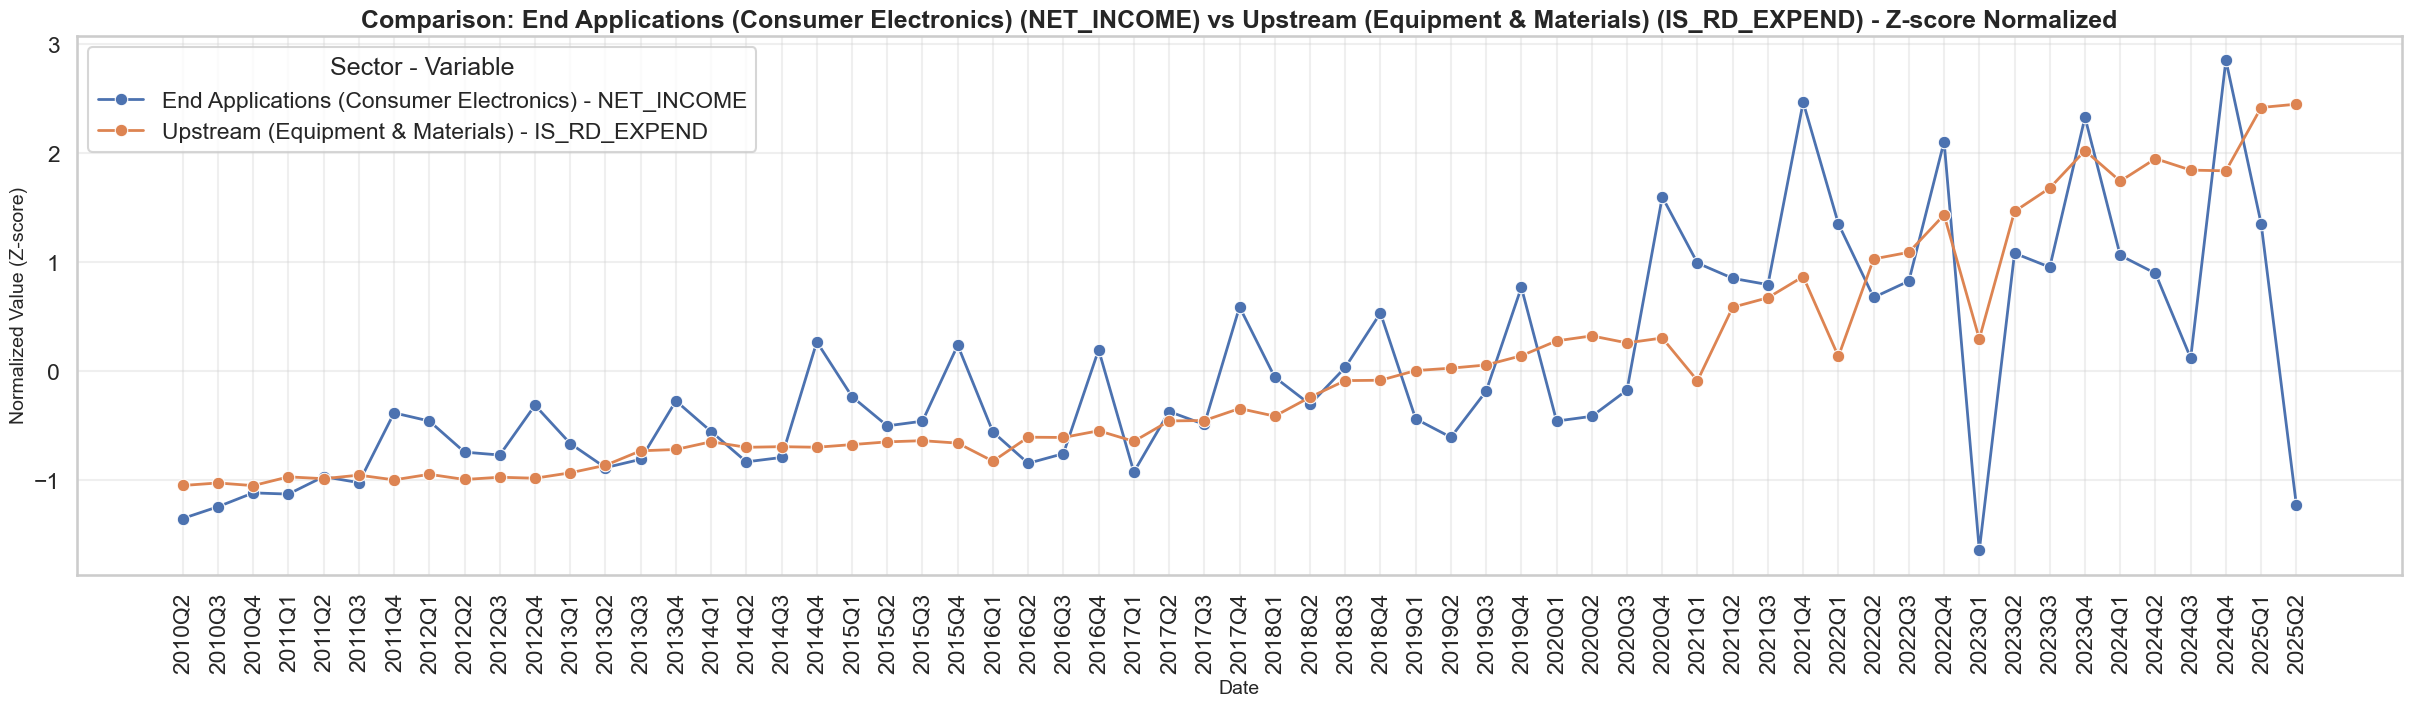

In [13]:
sectors_to_plot = [
    'End Applications (Consumer Electronics)',
    'Upstream (Equipment & Materials)'
]
plot_sector_comparison(sector_df, 'End Applications (Consumer Electronics)', 'NET_INCOME',
                       'Upstream (Equipment & Materials)', 'IS_RD_EXPEND',lag=0)